In [13]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
from scipy.sparse import csc_array
from pymrm import construct_grad, construct_convflux_upwind, interp_cntr_to_stagg_tvd, minmod, construct_div, newton, construct_coefficient_matrix, NumJac, non_uniform_grid, update_csc_array_indices, construct_convflux_upwind, construct_interface_matrices
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pymrm.solve import newton

In [ ]:
class ParticleModel:
    """
    1D diffusion-convection-reaction model with nonlinear kinetics, dynamic porosity and heat transfer.

    This class solves transient or steady-state mass and energy balances in a porous spherical particle.
    It supports arbitrary nonlinear reaction kinetics, time-dependent porosity, and temperature-dependent
    effective conductivity (conduction + radiation). 

    It builds the full Jacobian matrix and residual vector for implicit time integration with Newton's method.
    The model can be used for single particles or coupled to reactor-scale simulations.

    Parameters
    ----------
    shape : tuple
        Shape of the concentration field (number of grid points, number of components).
    axis : int, optional
        Axis along which diffusion and convection occur (default: 0).
    L : float, optional
        Length of the domain (default: 1.0).
    v : float or array, optional
        Velocity profile (default: 1.0).
    D : float or array, optional
        Diffusion coefficients (default: 0.0).
    c_0 : float or array, optional
        Initial concentration field (default: 0.0).
    h_mass : float, optional
        Mass transfer coefficient for outer boundary (default: 1.0).
    T_g : float, optional
        External gas temperature for boundary condition (default: 873.0).
    rho_bulk : array, optional
        Bulk gas density for boundary mass transfer (default: None).
    dt : float, optional
        Time step size (default: np.inf for steady-state).
    callback_newton : callable, optional
        Callback for Newton iteration (default: None).

    Attributes
    ----------
    c : ndarray
        Concentration field [kg/m³] and Temperature [K] for all components.
    c_old : ndarray
        Previous concentration field (for time stepping).
    z_f, z_c : ndarray
        Face and center grid points.
    eps_p : ndarray
        Local porosity field.
    jac_const : sparse matrix
        Constant part of the Jacobian.
    g_const : ndarray
        Constant part of the residual.
    """

    def __init__(self, shape, axis=0, L=1.0, v=1.0, D=0.0,
                 c_0=0.0, T_g=873.0, Re= 1.0, rho_bulk=None, dt=np.inf, callback_newton=None):
        # Model parameters
        self.shape = shape
        self.axis = axis
        self.L = L
        self.v = np.asarray(v)
        self.D = np.asarray(D)
        self.dt = dt
        self.T_g = T_g
        self.rho_bulk = np.asarray(rho_bulk)
        self.Re = Re

        # Porosity model constants
        self.eps_B0 = 0.4
        self.eps_Cf = 0.91
        self.rho_B0 = c_0[0,0]
        self.rho_Cf = c_0[0,0]
        self.kg = 2.577e-2
        self.viscos_bulk = 123.37e-6 # m^2/s
        
        # Grid initialization
        self.z_f = np.linspace(0, self.L, self.shape[self.axis] + 1)
        self.z_c = 0.5 * (self.z_f[:-1] + self.z_f[1:])
        self.init_field(c_0)
    
        # Jacobian helper
        self.callback_newton = callback_newton
        self.numjac = NumJac(shape)
    
    def init_field(self, c_0=0):
        """
        Initialize the concentration field with a uniform value.
        """
        # Concentration field
        c = np.asarray(c_0)
        shape = (1,) * (len(self.shape) - c.ndim) + c.shape
        c = c.reshape(shape)
        self.c = np.broadcast_to(c, self.shape).copy()
        self.c_old = self.c.copy()
    
        # Porosity field
        self.eps_p = np.ones(self.shape)
        self.eps_p_old = np.ones(self.shape)
        for j in [1, 2, 5, 6]: # set porosity for all gas species
            self.eps_p[:, j] = self.eps_B0
            self.eps_p_old[:, j] = self.eps_B0

    def update_kinetics(self, c, eps_p, Cp_total):
        """
        Compute reaction rates and heat source terms, returns R_out [kg/m³/s]
        """
        c = c.reshape(self.shape)
        B, Tar, G, C, M, W, I, T = [c[..., j] for j in range(8)]
    
        # Kinetics parameters
        p = {
            'A1': 4.38e9, 'E1': 152.7e3,
            'A2': 1.08e10, 'E2': 147e3,
            'A3': 3.27e6, 'E3': 111.7e3,
            'A4': 4.28e6, 'E4': 107.5e3,
            'A5': 1e5, 'E5': 108e3,
            'Avap': 5.13e10, 'Evap': 88e3,
            'R': 8.314
        }
    
        R = p['R']
        k = {
            'K1': p['A1'] * np.exp(-p['E1'] / (R * T)),
            'K2': p['A2'] * np.exp(-p['E2'] / (R * T)),
            'K3': p['A3'] * np.exp(-p['E3'] / (R * T)),
            'K4': p['A4'] * np.exp(-p['E4'] / (R * T)),
            'K5': p['A5'] * np.exp(-p['E5'] / (R * T)),
            'Kvap': p['Avap'] * np.exp(-p['Evap'] / (R * T)),
        }
    
        delta_H = {
            'dH1': 64000.0, 'dH2': 64000.0, 'dH3': 64000.0,
            'dH4': -42000.0, 'dH5': -42000.0, 'dHvap': 2.44e6
        }
    
        # Reaction rates
        R1 = k['K1'] * B
        R2 = k['K2'] * B
        R3 = k['K3'] * B
        R4 = k['K4'] * eps_p[..., 1] * Tar
        R5 = k['K5'] * eps_p[..., 1] * Tar
        Rvap = k['Kvap'] * M
    
        # Mass source terms
        R_out = np.zeros_like(c)
        R_out[..., 0] = -(R1 + R2 + R3)
        R_out[..., 1] = R2 - (R4 + R5)
        R_out[..., 2] = R1 + R4
        R_out[..., 3] = R3 + R5
        R_out[..., 4] = -Rvap
        R_out[..., 5] = Rvap
        R_out[..., 6] = 0
    
        # Energy source term
        Qdot = -(
            R1 * delta_H['dH1'] + R2 * delta_H['dH2'] + R3 * delta_H['dH3'] +
            R4 * delta_H['dH4'] + R5 * delta_H['dH5'] + Rvap * delta_H['dHvap']
        )
        R_out[..., 7] = Qdot / (Cp_total + 1e-8)
    
        return R_out

    def update_porosity(self):
        """
        Update porosity field based on biomass conversion for gas-phase components only.
        Solid-phase components (B, M, C) keep eps_p = 1.
        """
        rho_B = self.c[:, 0]
        rho_C = self.c[:, 3]
        XB = (self.rho_B0 - (rho_B + rho_C)) / (self.rho_B0 - self.rho_Cf + 1e-12)
    
        self.XB = np.clip(XB, 0.0, 1.0)
        eps_dynamic = self.eps_B0 * (1 - self.XB) + self.eps_Cf * self.XB
        eps_dynamic = np.clip(eps_dynamic, self.eps_B0, self.eps_Cf)
    
        self.eps_p = np.ones_like(self.c)
    
        # Gas phase components
        for j in [1, 2, 5, 6]:
            self.eps_p[:, j] = eps_dynamic

    def update_bc(self):
            """
            Update boundary conditions using current effective diffusivity D_eff = eps_p * D,
            and apply Robin BC for heat transfer (convection + radiation) at particle surface.
            Uses linearized radiation term for numerical stability.
            """
            Nc = self.shape[1]
            dpore_boundary = 5e-5 # m
        
            # Effective diffusion
            D_eff_center = self.eps_p * self.D
            D_eff_center[:, -1] = self.keff / self.Cp_total
            D_eff_face = 0.5 * (D_eff_center[:-1] + D_eff_center[1:])
            D_face_L = D_eff_center[0]
            self.D_face_R = 2 * D_eff_face[-1] - D_eff_face[-2]
            self.D_eff_face = np.vstack([D_face_L, D_eff_face, self.D_face_R])

            Nu = 0.03 * self.Re ** 1.3 # valid if Reynolds < 100 (expected Re 3.2)
            h_conv = Nu*self.kg / (dpore_boundary)

            Sc = (self.viscos_bulk) / ( self.D_face_R[6] + 1e-6)
            Sh = 2 + 0.6 * Sc ** (1/3) * self.Re**(1/2)

            self.h_mass = Sh * self.D_face_R[6] / (dpore_boundary)
 
            # Heat transfer
            sigma = 5.67e-8
            ems = 0.9
            T_surface = self.c[-1, 7]
        
            h_rad = 4 * ems * sigma * T_surface**3
            h_eff = h_conv + h_rad
        
            # Left BC (r = 0): zero flux
            bc_L = {
                'a': [[1 if i in [1, 2, 5, 6, 7] else 0 for i in range(Nc)]],
                'b': [[0] * Nc],
                'd': [[0.0] * Nc]
            }
        
            # Right BC (r = R): Robin BC for gas & temperature
            bc_R = {
                'a': [[
                    self.D_face_R[i] if i in [1, 2, 5, 6] else
                    -self.keff[-1] if i == 7 else 0
                    for i in range(Nc)]
                ],
                'b': [[
                    -self.h_mass if i in [1, 2, 5, 6] else 
                    -h_eff if i == 7 else 0
                    for i in range(Nc)]
                ],
                'd': [[
                    -self.h_mass * self.rho_bulk[i] if i in [1, 2, 5, 6] else
                    -h_eff * self.T_g if i == 7 else 0
                    for i in range(Nc)]
                ]
            }
        
            self.bc = (bc_L, bc_R)
        

    def update_heat_capacity(self):
        """
        Update total heat capacity term Cp_total [J/m³·K] for energy balance:
        """

        Cp_B = 2300.0
        Cp_C = 1700.0
        Cp_G = 1250.0
        Cp_T = 2500.0
        Cp_W = 1996.0
        Cp_I = 1040.0
        Cp_M = 4180.0
    
        rho_B = self.c[:, 0]
        rho_T = self.c[:, 1]
        rho_G = self.c[:, 2]
        rho_C = self.c[:, 3]
        rho_M = self.c[:, 4]
        rho_W = self.c[:, 5]
        rho_I = self.c[:, 6]
    
        # Gas phase
        self.rho_total_g = rho_G + rho_T + rho_W + rho_I
        self.Cp_g_mix = (
            rho_G * Cp_G +
            rho_T * Cp_T +
            rho_W * Cp_W +
            rho_I * Cp_I
        ) / (self.rho_total_g + 1e-6)
    
        # Total Cp
        self.Cp_total = (
            rho_B * Cp_B +
            rho_C * Cp_C +
            rho_M * Cp_M +
            self.eps_p[:, 2] * self.rho_total_g * self.Cp_g_mix
        )


    def update_vT_profile(self):
        """
        Update convection velocity term for Temperature equation:
        """
        # Compute v_T(r)
        self.vT_term = self.rho_total_g * self.Cp_g_mix / (self.Cp_total + 1e-8)

    def update_heatcoeff(self):
        T = self.c[:, -1]
    
        kB0_along = 0.255
        kB0_across = 0.1046
        kCf_along = 0.105
        kCf_across = 0.071
        wb0 = 0.6
        wcf = 1
        dpore_B0 = 5e-5 # m
        dpore_Cf = 1e-3 # m
        sigma = 5.67e-8
    
        self.dpore = dpore_B0 * (1 - self.XB) + dpore_Cf * self.XB
        wp = wb0 * (1 - self.XB) + wcf * self.XB
        kB0 = 0.5 * (kB0_along + kB0_across)
        kCf = 0.5 * (kCf_along + kCf_across)
    
        # Thermal conductivity
        kp = kB0 * (1 - self.XB) + kCf * self.XB
        kcond = kp + self.eps_p[:, 1] * self.kg
    
        # Radiation term
        krad = (4 * wp * self.eps_p[:, 1] * sigma * T**3 * self.dpore) / (1 - self.eps_p[:, 1] + 1e-8)
    
        self.keff = kcond + krad

    def update_jac(self):
        """
        Construct the Jacobian matrix and constant terms for the system.
        """
    
        vT_face = 0.5 * (self.vT_term[:-1] + self.vT_term[1:])
        vT_faces = np.tile(self.v, (self.shape[0] + 1, 1)) #(Nr + 1, Nc)
        vT_faces[1:-1, 7] = vT_face #T no edges
        vT_faces[0, 7] = self.vT_term[0] #1st edge
        vT_faces[-1, 7] = 2 * vT_face[-1] - vT_face[-2] #N+1 linear extrapolation
        self.vT_faces = vT_faces
        v_faces = self.v * vT_faces # (Nc) * (Nr + 1, Nc)

        # Construct the Jacobian matrix and constant terms for the system
        grad_mat, grad_bc  = construct_grad(self.shape, self.z_f, self.z_c, self.bc, axis=self.axis)  # Gradient operator
        self.div_mat = construct_div(self.c.shape, self.z_f,nu=2, axis=self.axis)  # Divergence operator
        diff_mat = construct_coefficient_matrix(self.D_eff_face, shape=self.shape, axis=self.axis)
        convflux_mat, convflux_bc = construct_convflux_upwind(self.shape, self.z_f, self.z_c, self.bc, axis=self.axis, v = v_faces)  # Convection flux operator 
        jac_convdiff = self.div_mat @ (convflux_mat -diff_mat @ grad_mat) #- div_v_mat # Diffusion term
        self.g_const = self.div_mat @ (convflux_bc -diff_mat @ grad_bc)  # Boundary condition forcing term
        jac_accum = construct_coefficient_matrix(1.0/self.dt, shape = self.shape)  # Accumulation term
        self.jac_const = jac_accum + jac_convdiff  # Total Jacobian matrix

    def g(self, c):
        """
        Compute the residual vector and Jacobian matrix for the current time step.
        """
        c_new = c.reshape(self.shape)
        self.c[...] = c_new
    
        # Update fields
        self.update_porosity()
        self.update_heat_capacity()
        self.update_vT_profile()
        self.update_kinetics(self.c, self.eps_p, self.Cp_total)
        self.update_heatcoeff()
        self.update_bc()
        self.update_jac()
    
        # TVD interpolation
        _ , dc_f = interp_cntr_to_stagg_tvd(self.c, self.z_f, self.z_c, self.bc, self.v, minmod)
        _ , deps_f = interp_cntr_to_stagg_tvd(self.eps_p, self.z_f, self.z_c, self.bc, self.v, minmod)

        # Convection term
        dg_conv = self.div_mat @ (deps_f * self.v * self.vT_faces * dc_f).reshape((-1, 1))
    
        # Assemble residual
        g = self.g_const + self.jac_const @ (self.eps_p * c).reshape(-1, 1) + dg_conv - (self.eps_p_old * self.c_old).reshape(-1, 1) / self.dt
    
        # Reaction source terms
        g_react, jac_react = self.numjac(lambda x: self.update_kinetics(x, self.eps_p, self.Cp_total), self.c)

        g -= g_react.reshape((-1, 1))
        jac = self.jac_const - jac_react
    
        return g, jac

    def step_dt(self):
        """
        Store the current concentration and porosity field as the previous values for time stepping.
        """
        self.c_old = self.c.copy()
        self.eps_p_old = self.eps_p.copy()

    def solve(self):
        """
        Solve the system using Newton's method.
        """
        result = newton(lambda c: self.g(c), self.c, maxfev=10, callback=self.callback_newton)
        self.c[...] = result.x.reshape(self.c.shape)  # Update the concentration field

    def app_rate_surface_conc(self):
        """
        Compute mass concentrations, diffusive molar‐flux,
        and volumetric molar‐flux at the outer (r=L) boundary.

        Returns
        -------
        c_surface : ndarray, shape (Nc,)
            Mass concentration [kg/m³] at the surface node.
        Rate     : ndarray, shape (Nc,)
            Apparent reaction rate [kg/m³/s]
        """

        self.update_heat_capacity()     # This initializes Cp_total
        Rate_space = self.update_kinetics(self.c, self.eps_p, self.Cp_total)
        Rate = (3 / self.z_c[-1]**3) * np.trapezoid(Rate_space[:, :] * self.z_c[:, np.newaxis]**2, self.z_c, axis=0)

        dr = self.z_f[1] - self.z_f[0]
        dc_dr = (self.c[-1, :] * self.eps_p[-1, :] - self.c[-2, :]*self.eps_p[-2, :]) / dr
        
        # Fluxes
        D_eff_surf = self.D_face_R

        J_mass = - D_eff_surf * dc_dr * 3 / self.L

        return Rate, J_mass

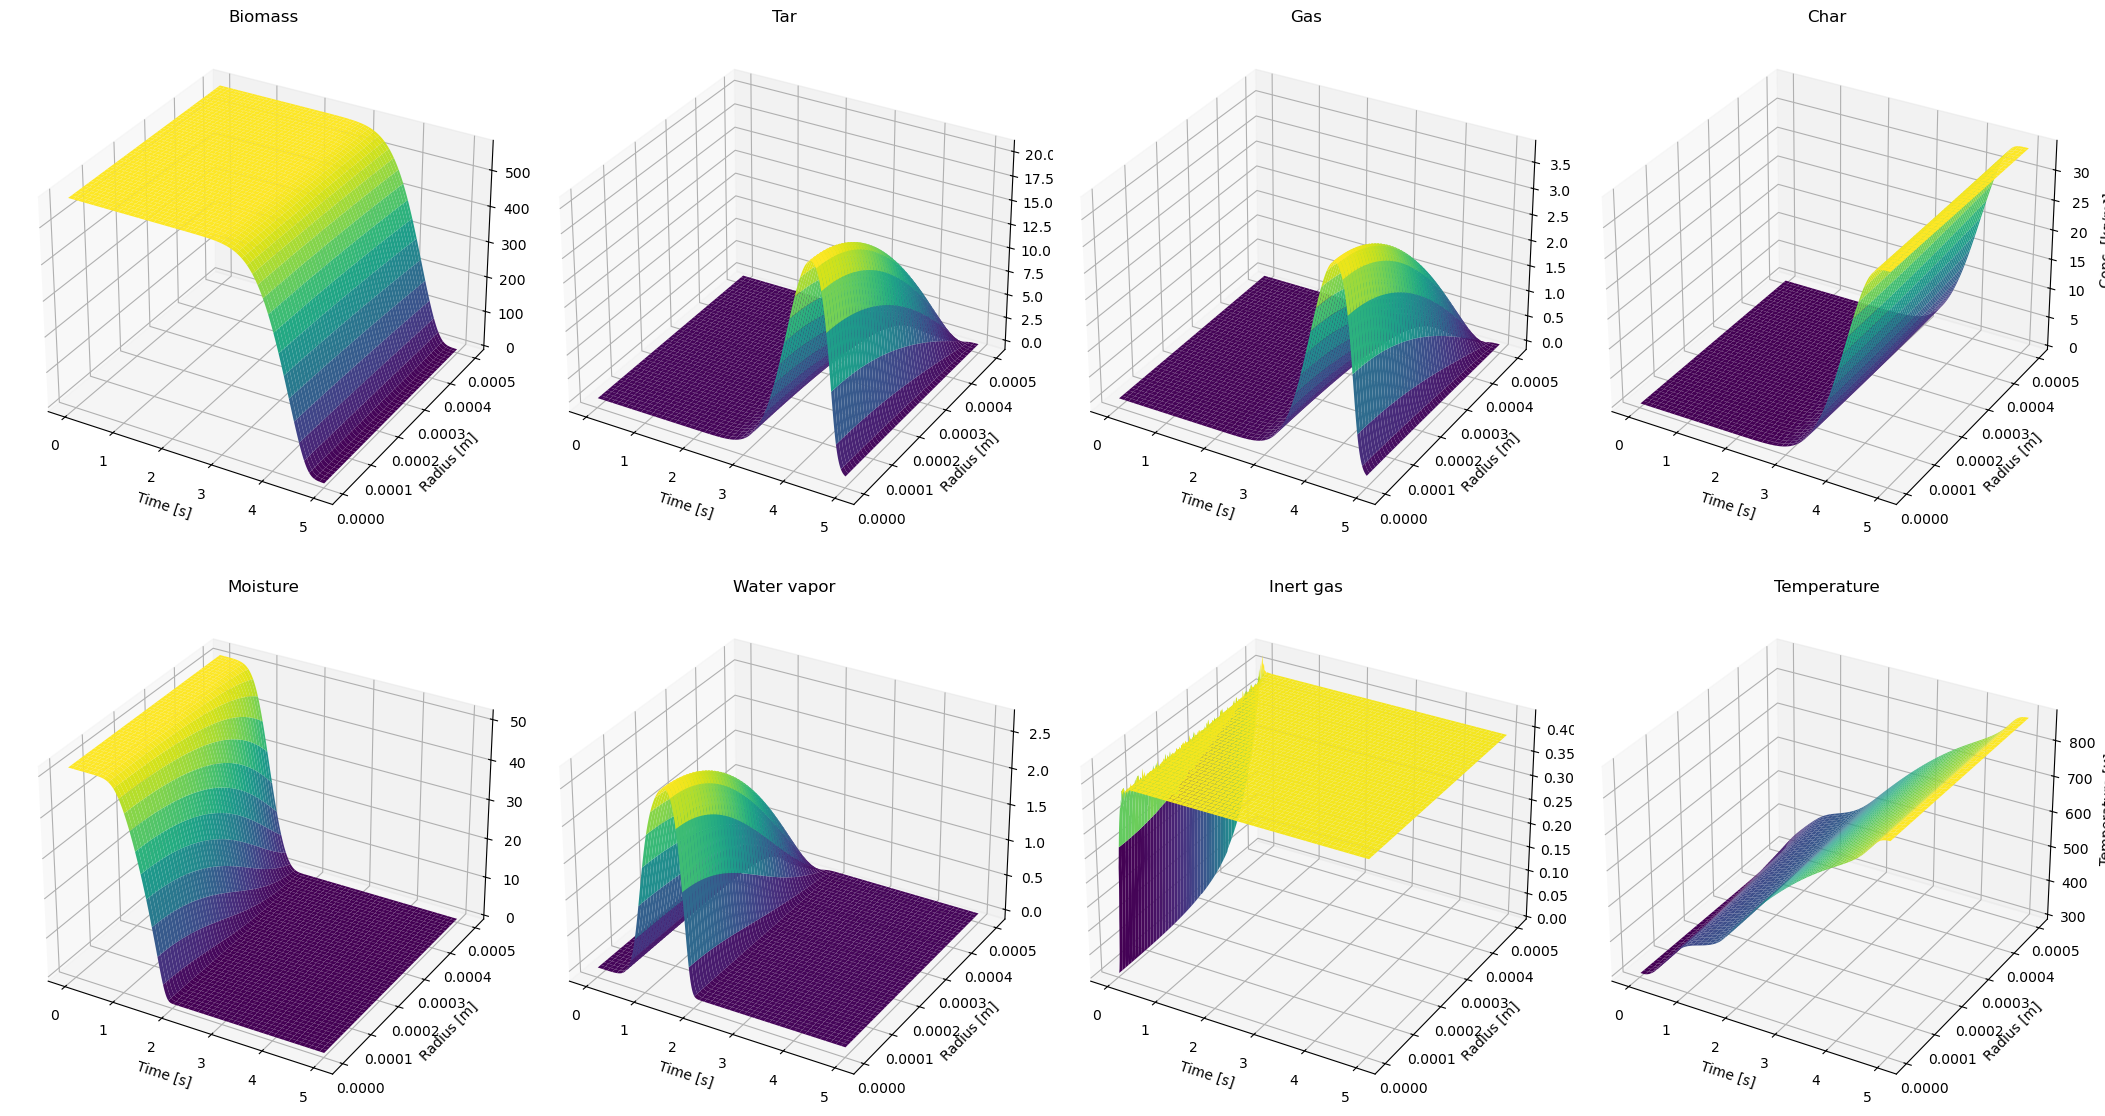

In [17]:

# --- Configuration ---
Nr = 200        # Radial grid points
Nc = 8          # Number of species
t_end = 5      # Total time [s]
Nt = 500        # Number of time steps
dt = t_end/Nt   # Time step [s]
R = 5e-4        # Particle radius [m]
R_univ = 8.314      # J/(mol·K)
P_atm  = 101325.0   # Pa
MW_N2  = 28e-3
shape_pm = (Nr, Nc)
T_g = 873
Re = 3.1937 # reynolds from fluidized bed

# Diffusion [m²/s] — only for Tar, Gas, Water vapor
D_vec = np.zeros(Nc)
D_vec[1] = 1e-6
D_vec[2] = 1e-6
D_vec[5] = 1e-6
D_vec[6] = 1e-6

r = np.linspace(0, R, Nr)
v_profile = np.zeros(Nc)
v_profile[1] = 1e-4   # velocity for Gas component [m/s]
v_profile[2] = 1e-4   # velocity for Gas component [m/s]
v_profile[5] = 1e-4   # velocity for Gas component [m/s]
v_profile[6] = 1e-4   # velocity for Gas component [m/s]
v_profile[7] = 1e-4   # velocity for Gas component [m/s]

# Initial conditions [kg/m³]
c0 = np.zeros(shape_pm)
c0[:, 0] = 570.0  # Biomass
c0[:, 4] = c0[:, 0] * 0.09    # Moisture
c0[:, 7] = 298    # Temp [K] 

rho_bulk = np.zeros(Nc)  # assumed 0 for now, can be changed
rho_bulk[6] = P_atm * MW_N2 / (R_univ * T_g)

model = ParticleModel(
    shape=shape_pm,
    axis=0,
    L=R,
    v=v_profile,
    D=D_vec,
    c_0=c0,
    dt=dt,
    Re= Re,
    rho_bulk=rho_bulk,
    T_g = T_g,
)

# --- Storage ---
r_vals = model.z_c
t_vals = np.linspace(dt, t_end, Nt)
all_conc = np.zeros((Nt, Nc, Nr))

# --- Time stepping ---
for step in range(Nt):
    model.step_dt()
    model.solve()
    all_conc[step] = (model.c * model.eps_p).T
    

# --- Plotting ---
component_names = ['Biomass', 'Tar', 'Gas', 'Char', 'Moisture', 'Water vapor', 'Inert gas', 'Temperature']
r_grid, t_grid = np.meshgrid(r_vals, t_vals)

fig = plt.figure(figsize=(21, 12))
for j in range(Nc):
    ax = fig.add_subplot(2, 4, j + 1, projection='3d')  # 2 rows, 4 columns
    ax.plot_surface(t_grid, r_grid, all_conc[:, j, :], cmap='viridis')
    ax.set_title(f"{component_names[j]}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Radius [m]")
    if j == 7:
        ax.set_zlabel("Temperature [K]")
    else:
        ax.set_zlabel("Conc. [kg/m³]")


plt.tight_layout()
plt.show()



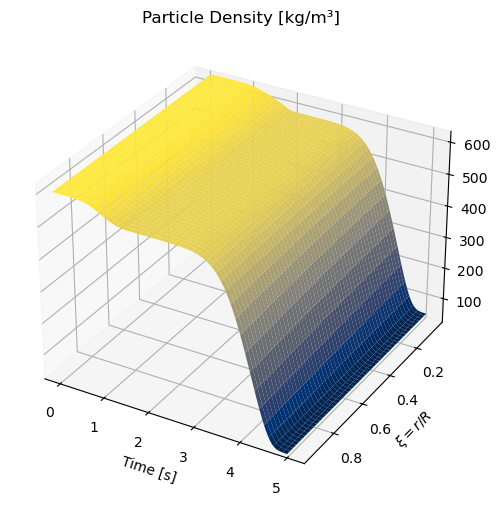

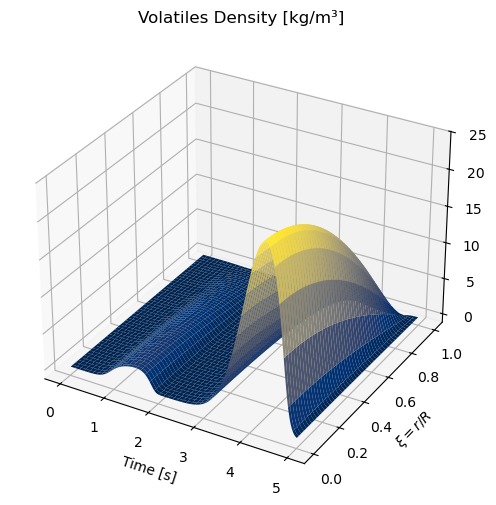

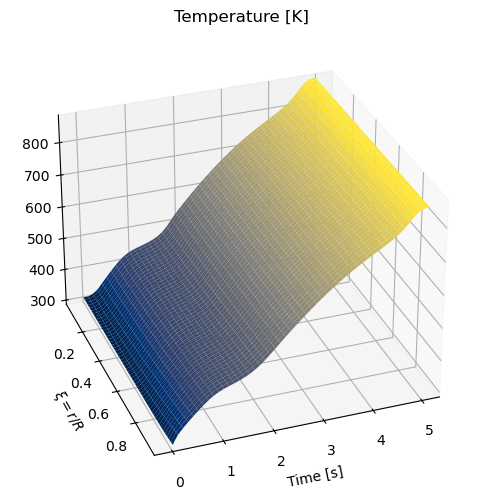

In [19]:
# --- Compute quantities ---
rho_p = all_conc[:, [0, 3, 4], :].sum(axis=1)    # Biomass + Char + Moisture
rho_vol = all_conc[:, [1, 2, 5], :].sum(axis=1)  # Tar + Gas + Vapor
T_profile = all_conc[:, 7, :]                    # Temperature

# Reverse radius axis: from R to 0
r_grid_rev, t_grid_rev = np.meshgrid(r_vals[::-1], t_vals)
rho_p_rev = rho_p[:, ::-1]
rho_vol_rev = rho_vol[:, ::-1]
T_rev = T_profile[:, ::-1]
xi_vals = r_vals / R
xi_grid_rev, t_grid_rev = np.meshgrid(xi_vals[::-1], t_vals)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, rho_p_rev, cmap='cividis')
ax.set_title("Particle Density [kg/m³]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
ax.set_ylim(xi_vals[-1], xi_vals[0])
# ax.set_zlabel("Density [kg/m³]")
ax.view_init(elev=30, azim=-60)
plt.savefig("Particle_DensityR5e-4.png", dpi=300, bbox_inches='tight')
plt.show()

# 2) Volatiles density
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, rho_vol_rev, cmap='cividis')
ax.set_title("Volatiles Density [kg/m³]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
# ax.set_ylim(xi_vals[-1], xi_vals[0])
ax.set_zlabel("Density [kg/m³]", rotation=0, labelpad=15)
# ax.view_init(elev=30, azim=100)
plt.savefig("Volatiles_DensityR5e-4.png", dpi=300, bbox_inches='tight')
plt.show()


# 3) Temperature
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, T_rev, cmap='cividis')
ax.set_title("Temperature [K]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
ax.set_ylim(xi_vals[-1], xi_vals[0])
ax.set_zlabel("Temperature [K]", rotation=0, labelpad=15)
ax.view_init(elev=30, azim=-110)
plt.savefig("TemperatureR5e-4.png", dpi=300, bbox_inches='tight')
plt.show()



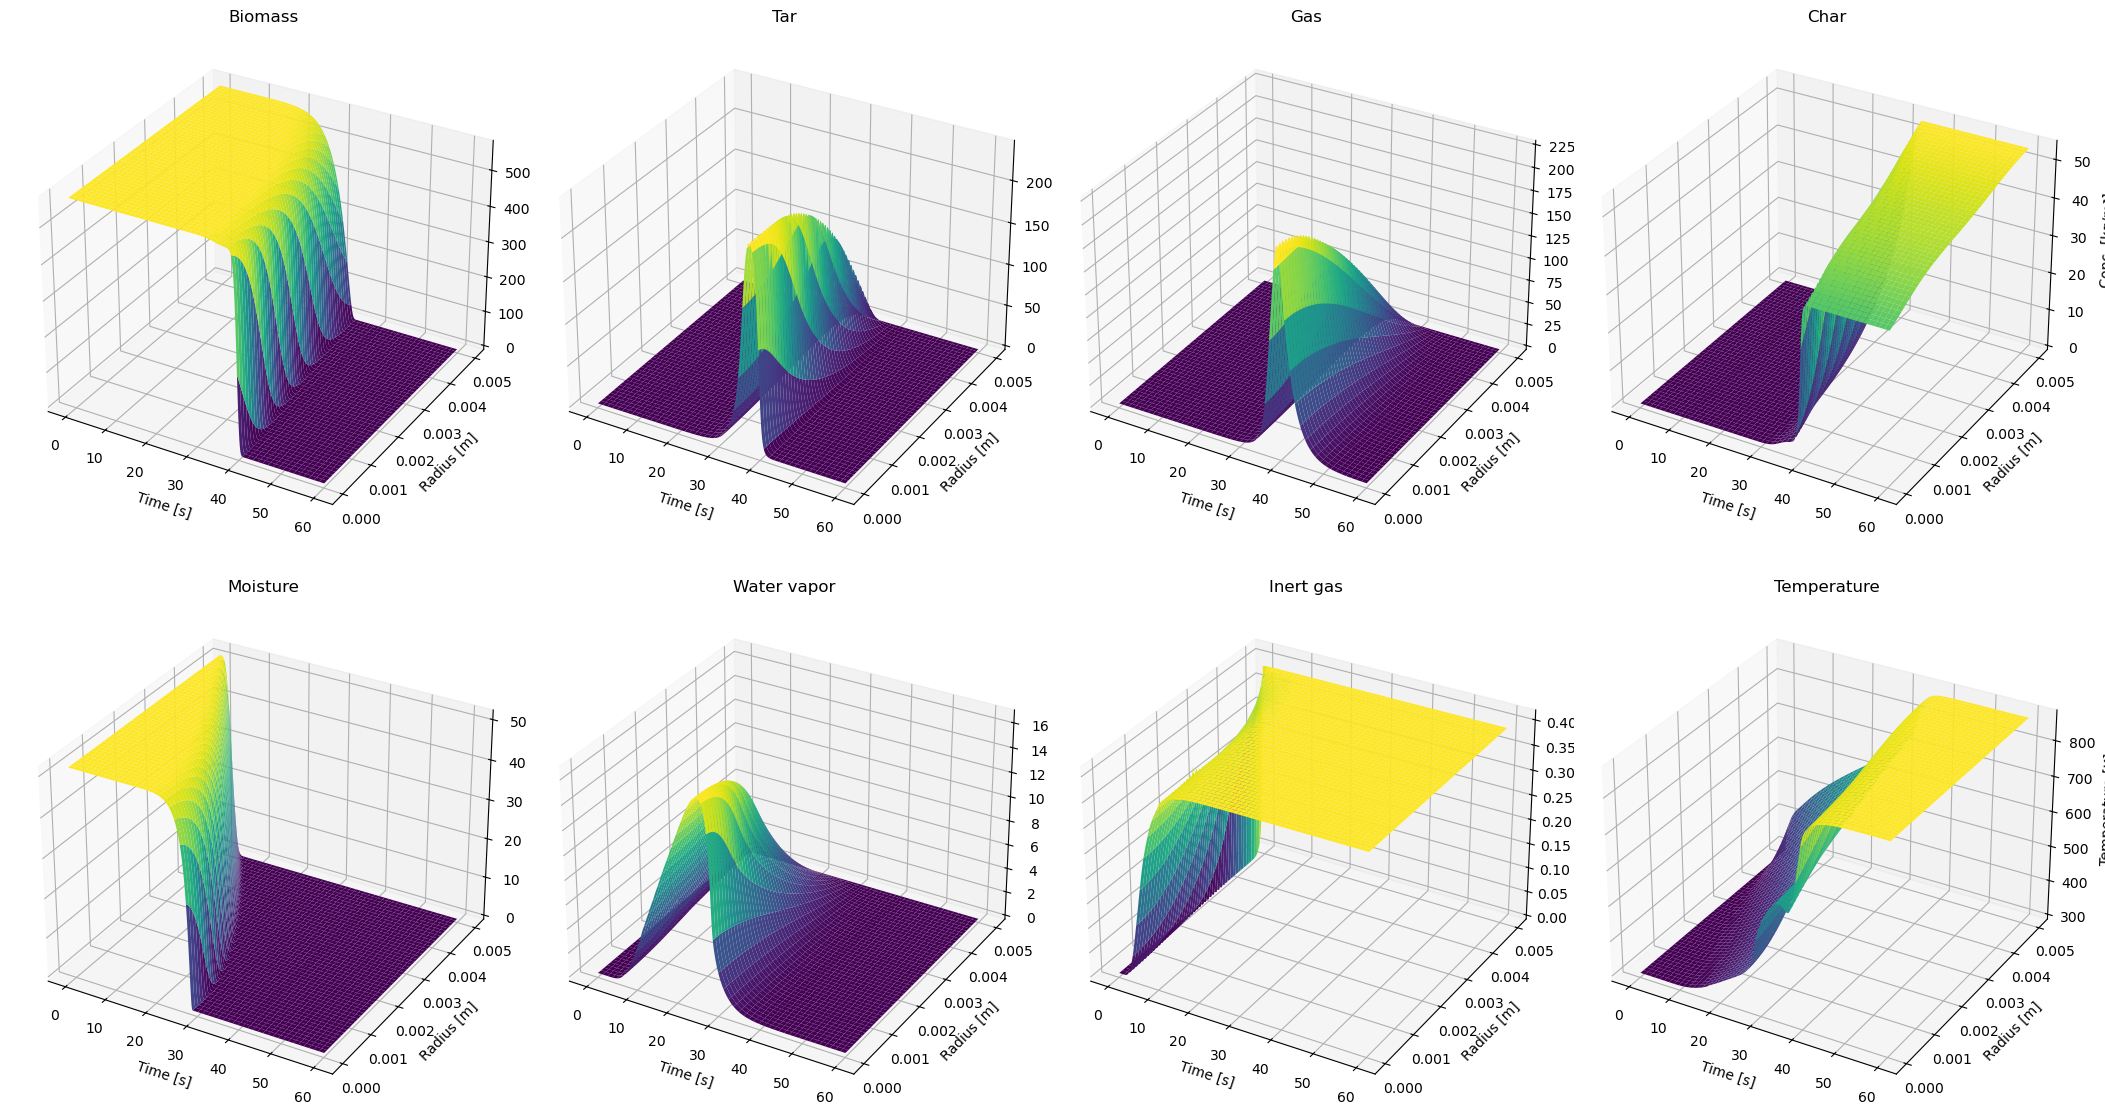

In [21]:

# --- Configuration ---
Nr = 200        # Radial grid points
Nc = 8          # Number of species
t_end = 60      # Total time [s]
Nt = 6000        # Number of time steps
dt = t_end/Nt   # Time step [s]
R = 5e-3        # Particle radius [m]
R_univ = 8.314      # J/(mol·K)
P_atm  = 101325.0   # Pa
MW_N2  = 28e-3
shape_pm = (Nr, Nc)
T_g = 873
Re = 3.1937 # reynolds from fluidized bed

# Diffusion [m²/s] — only for Tar, Gas, Water vapor
D_vec = np.zeros(Nc)
D_vec[1] = 1e-6
D_vec[2] = 1e-6
D_vec[5] = 1e-6
D_vec[6] = 1e-6

r = np.linspace(0, R, Nr)
v_profile = np.zeros(Nc)
v_profile[1] = 1e-4   # velocity for Gas component [m/s]
v_profile[2] = 1e-4   # velocity for Gas component [m/s]
v_profile[5] = 1e-4   # velocity for Gas component [m/s]
v_profile[6] = 1e-4   # velocity for Gas component [m/s]
v_profile[7] = 1e-4   # velocity for Gas component [m/s]

# Initial conditions [kg/m³]
c0 = np.zeros(shape_pm)
c0[:, 0] = 570.0  # Biomass
c0[:, 4] = c0[:, 0] * 0.09    # Moisture
c0[:, 7] = 298    # Temp [K] 

rho_bulk = np.zeros(Nc)  # assumed 0 for now, can be changed
rho_bulk[6] = P_atm * MW_N2 / (R_univ * T_g)

model = ParticleModel(
    shape=shape_pm,
    axis=0,
    L=R,
    v=v_profile,
    D=D_vec,
    c_0=c0,
    dt=dt,
    Re= Re,
    rho_bulk=rho_bulk,
    T_g = T_g,
)

# --- Storage ---
r_vals = model.z_c
t_vals = np.linspace(dt, t_end, Nt)
all_conc = np.zeros((Nt, Nc, Nr))

# --- Time stepping ---
for step in range(Nt):
    model.step_dt()
    model.solve()
    all_conc[step] = (model.c * model.eps_p).T
    

# --- Plotting ---
component_names = ['Biomass', 'Tar', 'Gas', 'Char', 'Moisture', 'Water vapor', 'Inert gas', 'Temperature']
r_grid, t_grid = np.meshgrid(r_vals, t_vals)

fig = plt.figure(figsize=(21, 12))
for j in range(Nc):
    ax = fig.add_subplot(2, 4, j + 1, projection='3d')  # 2 rows, 4 columns
    ax.plot_surface(t_grid, r_grid, all_conc[:, j, :], cmap='viridis')
    ax.set_title(f"{component_names[j]}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Radius [m]")
    if j == 7:
        ax.set_zlabel("Temperature [K]")
    else:
        ax.set_zlabel("Conc. [kg/m³]")


plt.tight_layout()
plt.show()



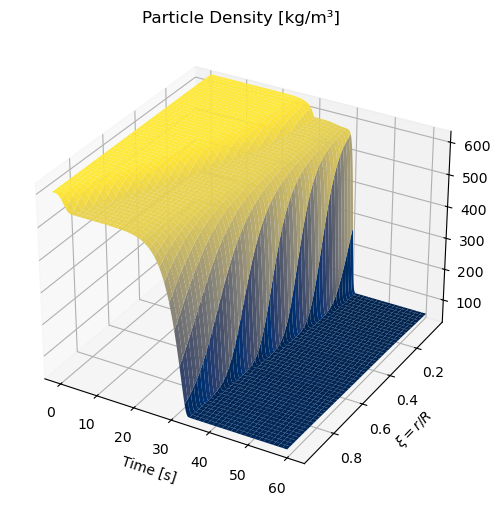

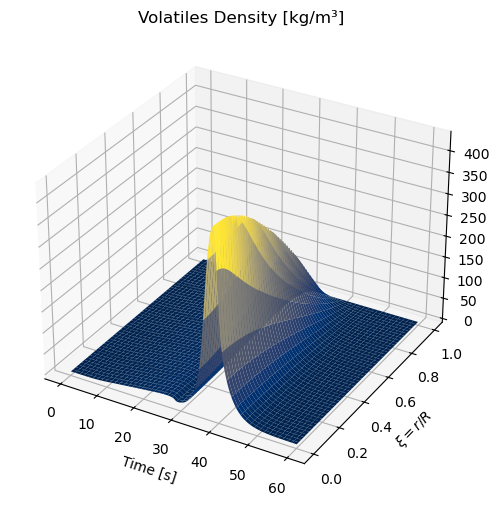

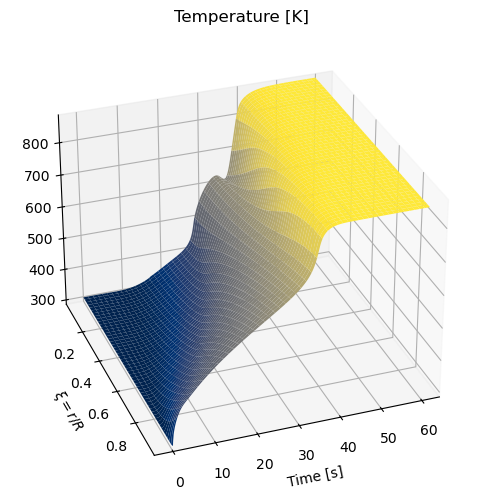

In [23]:
# --- Compute quantities ---
rho_p = all_conc[:, [0, 3, 4], :].sum(axis=1)    # Biomass + Char + Moisture
rho_vol = all_conc[:, [1, 2, 5], :].sum(axis=1)  # Tar + Gas + Vapor
T_profile = all_conc[:, 7, :]                    # Temperature

# Reverse radius axis: from R to 0
r_grid_rev, t_grid_rev = np.meshgrid(r_vals[::-1], t_vals)
rho_p_rev = rho_p[:, ::-1]
rho_vol_rev = rho_vol[:, ::-1]
T_rev = T_profile[:, ::-1]
xi_vals = r_vals / R
xi_grid_rev, t_grid_rev = np.meshgrid(xi_vals[::-1], t_vals)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, rho_p_rev, cmap='cividis')
ax.set_title("Particle Density [kg/m³]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
ax.set_ylim(xi_vals[-1], xi_vals[0])
# ax.set_zlabel("Density [kg/m³]")
ax.view_init(elev=30, azim=-60)
plt.savefig("Particle_DensityR5e-3.png", dpi=300, bbox_inches='tight')
plt.show()

# 2) Volatiles density
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, rho_vol_rev, cmap='cividis')
ax.set_title("Volatiles Density [kg/m³]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
# ax.set_ylim(xi_vals[-1], xi_vals[0])
ax.set_zlabel("Density [kg/m³]", rotation=0, labelpad=15)
# ax.view_init(elev=30, azim=100)
plt.savefig("Volatiles_DensityR5e-3.png", dpi=300, bbox_inches='tight')
plt.show()


# 3) Temperature
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(t_grid_rev, xi_grid_rev, T_rev, cmap='cividis')
ax.set_title("Temperature [K]")
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\xi = r/R$")
ax.set_ylim(xi_vals[-1], xi_vals[0])
ax.set_zlabel("Temperature [K]", rotation=0, labelpad=15)
ax.view_init(elev=30, azim=-110)
plt.savefig("TemperatureR5e-3.png", dpi=300, bbox_inches='tight')
plt.show()

